In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose whether to use gpu or cpu

In [3]:
output_root_folder = r"C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\6ClassHelical_1"
num_intervals = 20
output_folders = [os.path.join(output_root_folder, f"interval_{i + 1}") for i in range(num_intervals)]



In [7]:
# multi-input dataset
class CustomImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [sorted(os.listdir(folder[i]), key=self.custom_sort_key) for i in range(num_intervals)]
        # self.images1 = sorted(os.listdir(first_dir), key=self.custom_sort_key)
   

        self.labelsLast = [self.extract_label(img) for img in self.images[-1]]
        self.cuttime = [self.extract_cuttime(img) for img in self.images[-1]]
        
        #input verification
        assert len(self.images[0]) == len(self.images[1]) == len(self.images[2]) == len(self.images[3]) == len(self.images[4])

        self.length = len(self.images[0])

    def __len__(self):
        return self.length
        # return len(self.images1)

    def __getitem__(self, idx):
        image = [Image.open(os.path.join(self.folder[i], self.images[i][idx])) for i in range(num_intervals)]
        # img_name1 = os.path.join(self.first_dir, self.images1[idx])
        # image1 = Image.open(img_name1)

    
        if self.transform:
            image = [self.transform(image[i]) for i in range(num_intervals)]
            # image1 = self.transform(image1)

        labelLast = self.labelsLast[idx]
        cuttime = self.cuttime[idx]
        return image, labelLast, cuttime

    def custom_sort_key(self, item):
        # Extract numbers after 'Fig_' and 't-'
        fig_number = float(item.split('Fig_')[1].split('__')[0])
        t_number = float(item.split('t-')[1].split('_')[0])
        
        return fig_number, t_number
    
    def extract_label(self, img_name):
        # Assuming that the label is part of the filename before the first underscore
        # label = str(img_name)
        # print(label)

        label = float(img_name[-17:-5]) #this is the right code
        # print(label)

            
        return label
    
    def extract_cuttime(self, img_name):
        cuttime = float(img_name.split("t-")[1].split("_")[0])
        return cuttime

In [9]:
data_transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.45), (0.225))]) 

custom_dataset = CustomImageDataset(folder=output_folders, transform=data_transform)

# # Accessing the data
# for img, label in custom_dataset:
#     print(f"Image shape: {img.shape}, Label: {label}")

print(len(custom_dataset))

# train_set, val_set, test_set = random_split(custom_dataset, [int(len(custom_dataset)*0.75), int(len(custom_dataset)*0.15), int(len(custom_dataset)*0.100056)]) #splits data into training, validation and test sets
train_set, test_set = random_split(custom_dataset, [int(len(custom_dataset)*0.75), int(len(custom_dataset)*0.252)])
print(len(train_set))
# print(len(val_set))
print(len(test_set))

250
187
63


In [15]:
#hyperparameters
num_epochs = 60
batch_size = 1
learning_rate = 0.0005


train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test = DataLoader(test_set, batch_size=batch_size, shuffle=True)
for (image, labelsLast, cuttime) in train:
    print(image[0], labelsLast.item(), cuttime.item())
    break

tensor([[[[-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.],
          ...,
          [-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.]]]]) 5.158518 194.0


In [24]:
class ConvNet(nn.Module): # note need to find out image size
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,8,10, padding='same') #in_channels, out_channels, kernel_size
        self.normalise1 = nn.BatchNorm2d(8)
        # self.pool1 = nn.AvgPool2d(10, stride=10)
        self.pool1 = nn.AvgPool2d(10, stride=10)
        self.conv2 = nn.Conv2d(8, 16, 10, padding='same')
        self.normalise2 = nn.BatchNorm2d(16)
        # self.pool2 = nn.AvgPool2d(2, stride=2)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        self.pool3 = nn.AvgPool2d(1, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 10, padding='same')
        self.normalise3 = nn.BatchNorm2d(32) 
        self.conv4 = nn.Conv2d(32, 32, 10, padding='same')
        self.fc0 = nn.Linear(32*5*5, 400)

        self.convcomb1 = nn.Conv2d(1, 16, 20, padding='same')
        self.convcomb2 = nn.Conv2d(16, 32, 20, padding='same')
        
        self.fc1 = nn.Linear(16000+200, 8000)
        self.fc2 = nn.Linear(8000,4000)
        self.fc3 = nn.Linear(4000,2000)
        self.fc4 = nn.Linear(2000,1000)
        self.fc5 = nn.Linear(1000,500)
        self.fc6 = nn.Linear(500,150)
        self.fc7 = nn.Linear(150,75)
        self.fc8 = nn.Linear(75,15)
        self.fc9 = nn.Linear(15,1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(1,1)

    def initial_block(self, x):
        x = self.pool1(F.relu(self.normalise1(self.conv1(x)))) 
        x = self.pool2(F.relu(self.normalise2(self.conv2(x)))) 
        x = self.pool3(F.relu(self.normalise3(self.conv3(x))))
        x = self.pool3(F.relu(self.normalise3(self.conv4(x))))
        x = torch.flatten(x)
        x = self.fc0(x)
        return x
    def forward(self, images, t):
        images = [self.initial_block(images[i]) for i in range(num_intervals)]
        # print(images[0].shape)
        # print(images[19].shape)

        combined = torch.stack(images)
        combined = combined.unsqueeze(0)
        combined= combined.unsqueeze(0)
        # print(combined.shape)
        # print(combined)
        combined = self.pool2(F.relu(self.normalise2(self.convcomb1(combined)))) 
        # print(combined.shape)
        # print(combined)
        combined = self.pool2(F.relu(self.normalise3(self.convcomb2(combined)))) 
        # combined = combined.view(-1, 32*5*5)  #flatten
        combined = torch.flatten(combined)
        # print(combined.shape)
        t = self.fc(t)
        t = torch.flatten(t.repeat(1,200))
        # print(t.shape)
        # print(t)
        combined = torch.cat((combined, t), 0)
        # print(combined.shape)
        combined = F.relu(self.fc1(combined))
        combined = F.relu(self.fc2(combined))
        combined = F.relu(self.fc3(combined))
        combined = F.relu(self.fc4(combined))
        combined = F.relu(self.fc5(combined))
        combined = F.relu(self.fc6(combined))
        combined = F.relu(self.fc7(combined))
        combined = F.relu(self.fc8(combined))
        combined = self.fc9(combined)
        return combined

In [25]:
model = ConvNet().to(device)

# loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
#training loop
n_total_steps = len(train)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labelsLast, cuttimes) in enumerate(train):
        images = [img.to(device) for img in images]
        # images1 = images1.to(device)
        
        labelsLast = labelsLast.to(device)
        cuttimes = cuttimes.to(device).float()

        #forward
        outputs = model(images, cuttimes)
        # print(labels)
        labelsLast = labelsLast.float()
        loss = criterion(outputs, labelsLast)

        #backward
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # if (i+1) % 1000 ==0:
        # print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
        total_loss += loss.item()
    print(f'epoch {epoch+1}/{num_epochs}, average loss = {total_loss/len(train):.4f}')
            


epoch 1/60, average loss = 18.0917
epoch 2/60, average loss = 12.2361
epoch 3/60, average loss = 5.6265
epoch 4/60, average loss = 3.5504
epoch 5/60, average loss = 3.2571
epoch 6/60, average loss = 3.5779
epoch 7/60, average loss = 2.4373
epoch 8/60, average loss = 1.6999
epoch 9/60, average loss = 1.3410
epoch 10/60, average loss = 0.7567
epoch 11/60, average loss = 1.0678
epoch 12/60, average loss = 2.1246
epoch 13/60, average loss = 2.1567
epoch 14/60, average loss = 0.9626
epoch 15/60, average loss = 0.8532
epoch 16/60, average loss = 0.4000
epoch 17/60, average loss = 0.7512
epoch 18/60, average loss = 0.4489
epoch 19/60, average loss = 0.5303
epoch 20/60, average loss = 0.8193
epoch 21/60, average loss = 0.5786
epoch 22/60, average loss = 3.1638
epoch 23/60, average loss = 1.2382
epoch 24/60, average loss = 0.8679
epoch 25/60, average loss = 0.7141
epoch 26/60, average loss = 0.4029
epoch 27/60, average loss = 0.4953
epoch 28/60, average loss = 0.9661
epoch 29/60, average loss =

RMSE = tensor([0.3443], dtype=torch.float64)
[7.659862041473389, 6.743544578552246, 6.620596408843994, 1.1398886442184448, 7.187906265258789, 9.280266761779785, 7.378147602081299, 7.704024791717529, 6.779092788696289, 9.20553970336914, 7.732480525970459, 1.8352515697479248, 6.5601043701171875, 11.863899230957031, 7.763472557067871, 7.769781589508057, 11.861316680908203, 11.86522102355957, 1.0316250324249268, 7.670632362365723, 11.87934398651123, 6.843127250671387, 7.725895881652832, 1.0044662952423096, 7.667308330535889, 6.87980318069458, 1.0018737316131592, 8.358359336853027, 7.739077091217041, 7.925915718078613, 11.07276725769043, 7.844362258911133, 6.755424499511719, 7.72450065612793, 11.8765230178833, 7.251945495605469, 11.864253044128418, 1.884777307510376, 1.010157585144043, 6.878518104553223, 5.943018436431885, 6.594311714172363, 7.666957378387451, 11.863693237304688, 6.843216896057129, 8.200904846191406, 7.666410446166992, 1.138425588607788, 5.927142143249512, 6.842939376831055

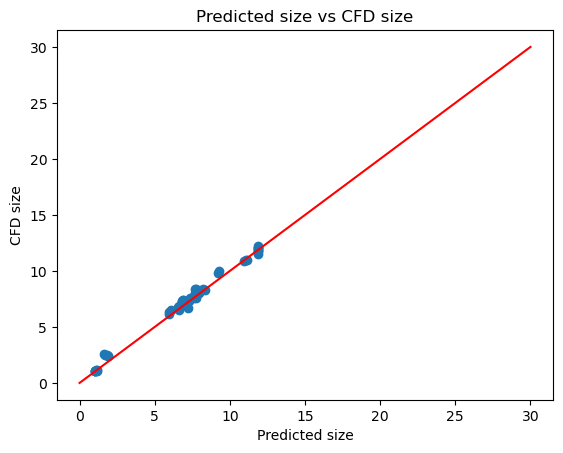

In [27]:
#Testing
with torch.no_grad(): # no need to calculate gradient
    squared_difference = 0
    predicted_size_data = []
    CFD_size_data = []
    for (images, labelsLast, cuttimes) in test:
        images = [img.to(device) for img in images]
        labelsLast = labelsLast.to(device)

        cuttimes = cuttimes.to(device).float()

        #forward
        outputs = model(images, cuttimes)
    
        # print(predictions)
        squared_difference += (float(outputs) - labelsLast) ** 2
        predicted_size_data.append(float(outputs))
        CFD_size_data.append(float(labelsLast))
    
    rmse = torch.sqrt(squared_difference / (len(test)))
    print(f'RMSE = {rmse}')
    print(predicted_size_data)
    print(CFD_size_data)
    plt.scatter(predicted_size_data, CFD_size_data)
    x = np.linspace(0, 30, 200)
    plt.plot(x, x, '-r')
    plt.xlabel('Predicted size')
    plt.ylabel('CFD size')
    plt.title('Predicted size vs CFD size')
    plt.show()

In [1]:
#save the model
# PATH = r'C:\Users\Chappyyyyyy\Desktop\PartIIB project 2023_2024\MultiInput\size_model.pth'
# torch.save(model.state_dict(), PATH)

NameError: name 'torch' is not defined

In [ ]:
#archived 
# class ConvNet(nn.Module): # note need to find out image size
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(1,30,20, padding='same') #in_channels, out_channels, kernel_size
#         self.normalise1 = nn.BatchNorm2d(30)
#         # self.pool = nn.AvgPool2d(5,5) #kernel_size, stride (shift x pixel to the right)
#         self.pool1 = nn.AvgPool2d(10, stride=10)
#         # self.pool1 = nn.MaxPool2d(10, stride=10)
#         self.conv2 = nn.Conv2d(30, 30, 20, padding='same')
#         # self.normalise2 = nn.BatchNorm2d(16)
#         # self.pool2 = nn.AvgPool2d(2, stride=2)
#         self.pool2 = nn.MaxPool2d(2, stride=2)
#         self.conv3 = nn.Conv2d(1, 30, 10, padding='same')
#         # self.normalise3 = nn.BatchNorm2d(32) 
#         self.conv4 = nn.Conv2d(30, 30, 10, padding='same')
#         self.fc0 = nn.Linear(30, 10)
#         self.fc = nn.Linear(32*5*5, 1)
#         self.fc1 = nn.Linear(60, 40)
#         self.fc2 = nn.Linear(40,20)
#         self.fc3 = nn.Linear(20,4)
#         self.dropout = nn.Dropout(0.1)

In [ ]:
# model_test = ConvNet().to(device)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, len(param.data))